In [1]:
%load_ext autoreload
%autoreload 2

import qubx

%qubxd
import pandas as pd
import numpy as np

from qubx.data.helpers import loader
from qubx.data.hft import HftDataReader

from qubx.core.metrics import tearsheet
from qubx.backtester.simulator import simulate
from qubx.core.metrics import chart_signals

from qubx.utils.misc import add_project_to_system_path

add_project_to_system_path("~/devs/Qubx")

from tests.strategies.obi_trader.models.obi_trader import ObiTraderStrategy


⠀⠀⡰⡖⠒⠒⢒⢦⠀⠀   
⠀⢠⠃⠈⢆⣀⣎⣀⣱⡀  QUBX | Quantitative Backtesting Environment 
⠀⢳⠒⠒⡞⠚⡄⠀⡰⠁         (c) 2025, ver. 0.6.1
⠀⠀⠱⣜⣀⣀⣈⣦⠃⠀⠀⠀ 
        


In [11]:
r = simulate(
    strategies={"Test": (stg := ObiTraderStrategy(tick_size_pct=0.1, depth=25, threshold=1.0))},
    data={"orderbook": HftDataReader()},
    capital=1000,
    instruments=["BINANCE.UM:BTCUSDT"],
    commissions=None,
    start="2025-01-01",
    stop="2025-01-15",
    portfolio_log_freq="1min",
    debug="WARNING",
)

Simulating:   0%|          | 0/100 [00:00<?, ?%/s]

,Gain,Cagr,Sharpe,Qr,Max dd pct,Mdd usd,Sortino,Calmar,Tail ratio,Stability,Var,Avg return,Fees,Execs
Test,231.089,224.928,8.589,3.434,7.221,86.863,22.568,4989.729,1.732,0.847,39.163,1.551,0.0,1036.0


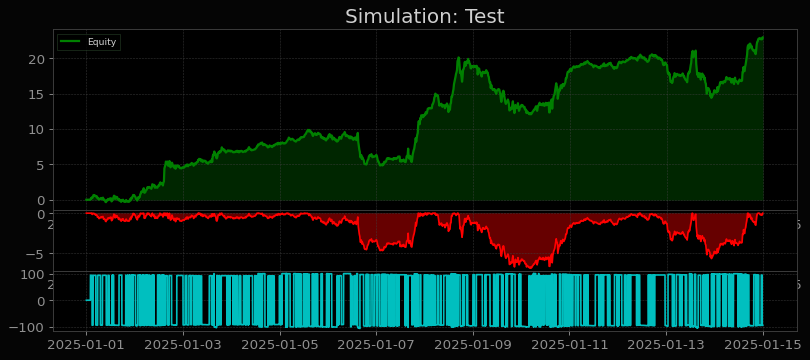

In [12]:
tearsheet(r, plot_leverage=True)

Plot signals

In [13]:
ld = loader("BINANCE.UM", "1min", source="mqdb::nebula")

In [ ]:
chart_signals(
    r[0],
    "BTCUSDT",
    ld["BTCUSDT", "2025-01-01":"2025-01-15"],
    indicators={"obi": stg._obi.pd(), "zscore_obi": stg._zscore_obi.pd()},
    timeframe="1min",
)